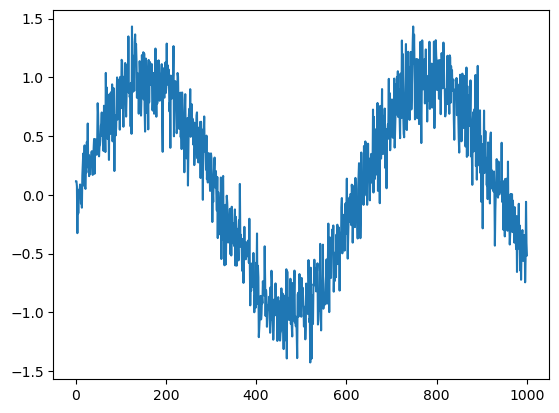

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
T=1000 #产生1000个点
time=tf.range(1,T+1,dtype=tf.float32)
time1=np.arange(1,1001)
x=tf.sin(0.01*time)+tf.random.normal([T],0,0.2)
x1=np.sin(0.01*time1)+np.random.normal(0,0.2,[T])
plt.plot(time,x)

In [39]:
def get_net():
    net=tf.keras.models.Sequential([tf.keras.layers.Dense(10,activation='relu'),
                                   tf.keras.layers.Dense(1)])
    
    return net

loss=tf.keras.losses.MeanSquaredError()
net=get_net()

In [41]:
def train(net,train_iter,loss,epochs,lr):
    trainer=tf.keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            with tf.GradientTape() as g:
                out=net(X)
                l=loss(y,out)
                params=net.trainable_variables
                grads=g.gradient(l,params)
            trainer.apply_gradients(zip(grads,params))
        print(f'epoch {epoch+1},',f'loss: {d2l.evaluate_loss(net,train_iter,loss)}')
        
train(net,train_iter,loss,5,0.001)

epoch 1, loss: 0.060099892661367595
epoch 2, loss: 0.05731680004024192
epoch 3, loss: 0.05489060858656701
epoch 4, loss: 0.05391179775132945
epoch 5, loss: 0.05195664761489943


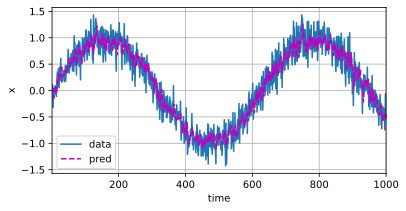

In [24]:
onestep_preds=net(features)
d2l.plot([time,time[tau:]],
        [x.numpy(),onestep_preds.numpy()],'time', 'x',legend=['data','pred'],xlim=[1,1000],figsize=(6,3))

# 多步时间预测的LSTM

In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('household_power_consumption.txt',sep=';',low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])
data.head()
#parse_date是将两列联合在一起

C:\Users\15295\AppData\Local\Temp\ipykernel_1180\1156603986.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data=pd.read_csv('household_power_consumption.txt',sep=';',low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])
C:\Users\15295\AppData\Local\Temp\ipykernel_1180\1156603986.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data=pd.read_csv('household_power_consumption.txt',sep=';',low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},index_col=['datetime'])
C:\Users\15295\AppData\Local\Temp\ipykernel_1180\1156603986.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [48]:
from numpy import nan
from numpy import isnan
from pandas import to_numeric

data.replace('?',nan,inplace=True)
data=data.astype('float32')

In [49]:
data.fillna(method='ffill',inplace=True)

**接下来的任务是对未来7天的总用功功率进行预测，是一个多步预测模型，考虑每天的**

In [78]:
daily_groups=data.resample('D')
daily_data=daily_groups.sum()
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [219]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
def split_data(data):
    train,test=data[1:-328],data[-328:-6]
    train=np.array(np.split(train,159))
    test=np.array(np.split(test,46))
    return train,test

train,test=split_data(daily_data.values)

In [220]:
train=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))

In [223]:
train=train[:,0]

In [224]:
def to_supervised(train,n_input,n_out=7):
    X,y=list(),list()
    in_start=0
    
    for _ in range(len(train)):
        in_end=in_start+n_input
        out_end=in_end+n_out
        
        if out_end<len(train):
            x_input=train[in_start:in_end]
            x_input=x_input.reshape(len(x_input),1)
            X.append(x_input)
            y.append(train[in_end:out_end])
        in_start+=1
    return np.array(X),np.array(y)


X_train,y_train=to_supervised(train,7,7)

In [255]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
epochs=70
batch_size=16

model=Sequential()
model.add(LSTM(200,activation='relu',input_shape=(7,1)))
model.add(Dense(100,activation='relu'))
model.add(Dense(7))
model.compile(loss='mse',optimizer='adam')

history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size)

Epoch 1/70
69/69 [==============================] - 2s 6ms/step - loss: 785994.2500
Epoch 2/70
69/69 [==============================] - 0s 6ms/step - loss: 279019.8125
Epoch 3/70
69/69 [==============================] - 0s 6ms/step - loss: 271914.7812
Epoch 4/70
69/69 [==============================] - 0s 6ms/step - loss: 267604.0000
Epoch 5/70
69/69 [==============================] - 0s 6ms/step - loss: 266594.8125
Epoch 6/70
69/69 [==============================] - 0s 6ms/step - loss: 264272.7812
Epoch 7/70
69/69 [==============================] - 0s 6ms/step - loss: 267130.7188
Epoch 8/70
69/69 [==============================] - 0s 6ms/step - loss: 266340.9062
Epoch 9/70
69/69 [==============================] - 0s 7ms/step - loss: 268813.0938
Epoch 10/70
69/69 [==============================] - 0s 6ms/step - loss: 260214.5312
Epoch 11/70
69/69 [==============================] - 0s 7ms/step - loss: 258222.0000
Epoch 12/70
69/69 [==============================] - 0s 6ms/step - loss: 2

In [242]:
input_x=np.array(daily_data.iloc[-7:,0])

In [243]:
input_x=input_x.reshape(-1,1)

In [248]:
input_x

array([[2197.006],
       [ 900.91 ],
       [2041.536],
       [1577.536],
       [1796.248],
       [1431.164],
       [1488.104]], dtype=float32)

In [256]:
y_pred=model.predict(input_x)

1/1 [==============================] - 0s 172ms/step


In [257]:
y_pred

array([[ 996.08813,  697.095  ,  626.73944,  859.31915,  799.9823 ,
        1076.962  , 1232.1064 ],
       [ 411.93527,  288.8466 ,  260.1807 ,  356.63217,  332.13086,
         446.00095,  510.75592],
       [ 926.1121 ,  648.19806,  582.8236 ,  799.055  ,  743.9069 ,
        1001.3236 , 1145.6624 ],
       [ 717.1654 ,  502.18173,  451.69583,  619.16144,  576.507  ,
         775.5231 ,  887.5801 ],
       [ 815.679  ,  571.0274 ,  513.51825,  703.96466,  655.4233 ,
         881.96936, 1009.25146],
       [ 651.20245,  456.08133,  410.30347,  562.39624,  523.67816,
         704.2689 ,  806.1232 ],
       [ 676.8663 ,  474.01755,  426.4074 ,  584.47955,  544.23065,
         731.989  ,  837.81384]], dtype=float32)

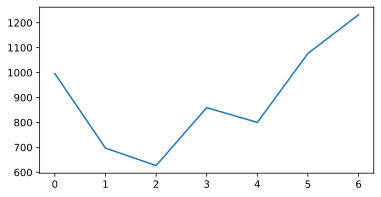

In [258]:
import matplotlib.pyplot as plt
plt.plot(y_pred[0])

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dense
from keras.models import Sequential
dataset=pd.read_csv('Air Quality.csv')
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [2]:
dataset.drop(columns=dataset.columns[-2:],axis=1,inplace=True)
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


In [4]:
dataset.describe().style.background_gradient(cmap='Blues').set_caption('描述性统计')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [5]:
dataset.drop(['NMHC(GT)'],axis=1,inplace=True)
dataset=dataset[dataset!=200].dropna().reset_index()

In [6]:
dataset.drop('Date',axis=1,inplace=True)



In [7]:
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
encoder=LabelEncoder()
dataset['Time']=encoder.fit_transform(dataset['Time'])

numerical_columns=dataset.select_dtypes(include=['int','float']).columns

scaler=StandardScaler()
dataset[numerical_columns]=scaler.fit_transform(dataset[numerical_columns])

dataset.head()

,index,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,-1.730958,0.940047,0.474546,0.943296,0.242880,0.443203,-0.008701,0.809152,0.433984,0.643199,0.642210,0.088838,0.183836,0.195140
1,-1.730588,1.084513,0.466825,0.737249,0.182528,0.177446,-0.253354,1.175332,0.268586,0.358610,-0.005431,0.081902,0.160429,0.194312
2,-1.730218,1.228978,0.469399,1.070560,0.172872,0.130720,-0.144619,1.069823,0.441861,0.350051,0.217743,0.049531,0.283314,0.194945
3,-1.729847,1.373443,0.469399,0.991777,0.177700,0.157004,0.014600,0.920868,0.504870,0.412104,0.499992,0.028721,0.400348,0.195880
4,-1.729477,1.517909,0.461678,0.676647,0.112520,-0.170082,-0.144619,1.271532,0.457613,0.210966,0.296510,0.033345,0.392546,0.195934


In [8]:
dataset.drop('index',axis=1,inplace=True)

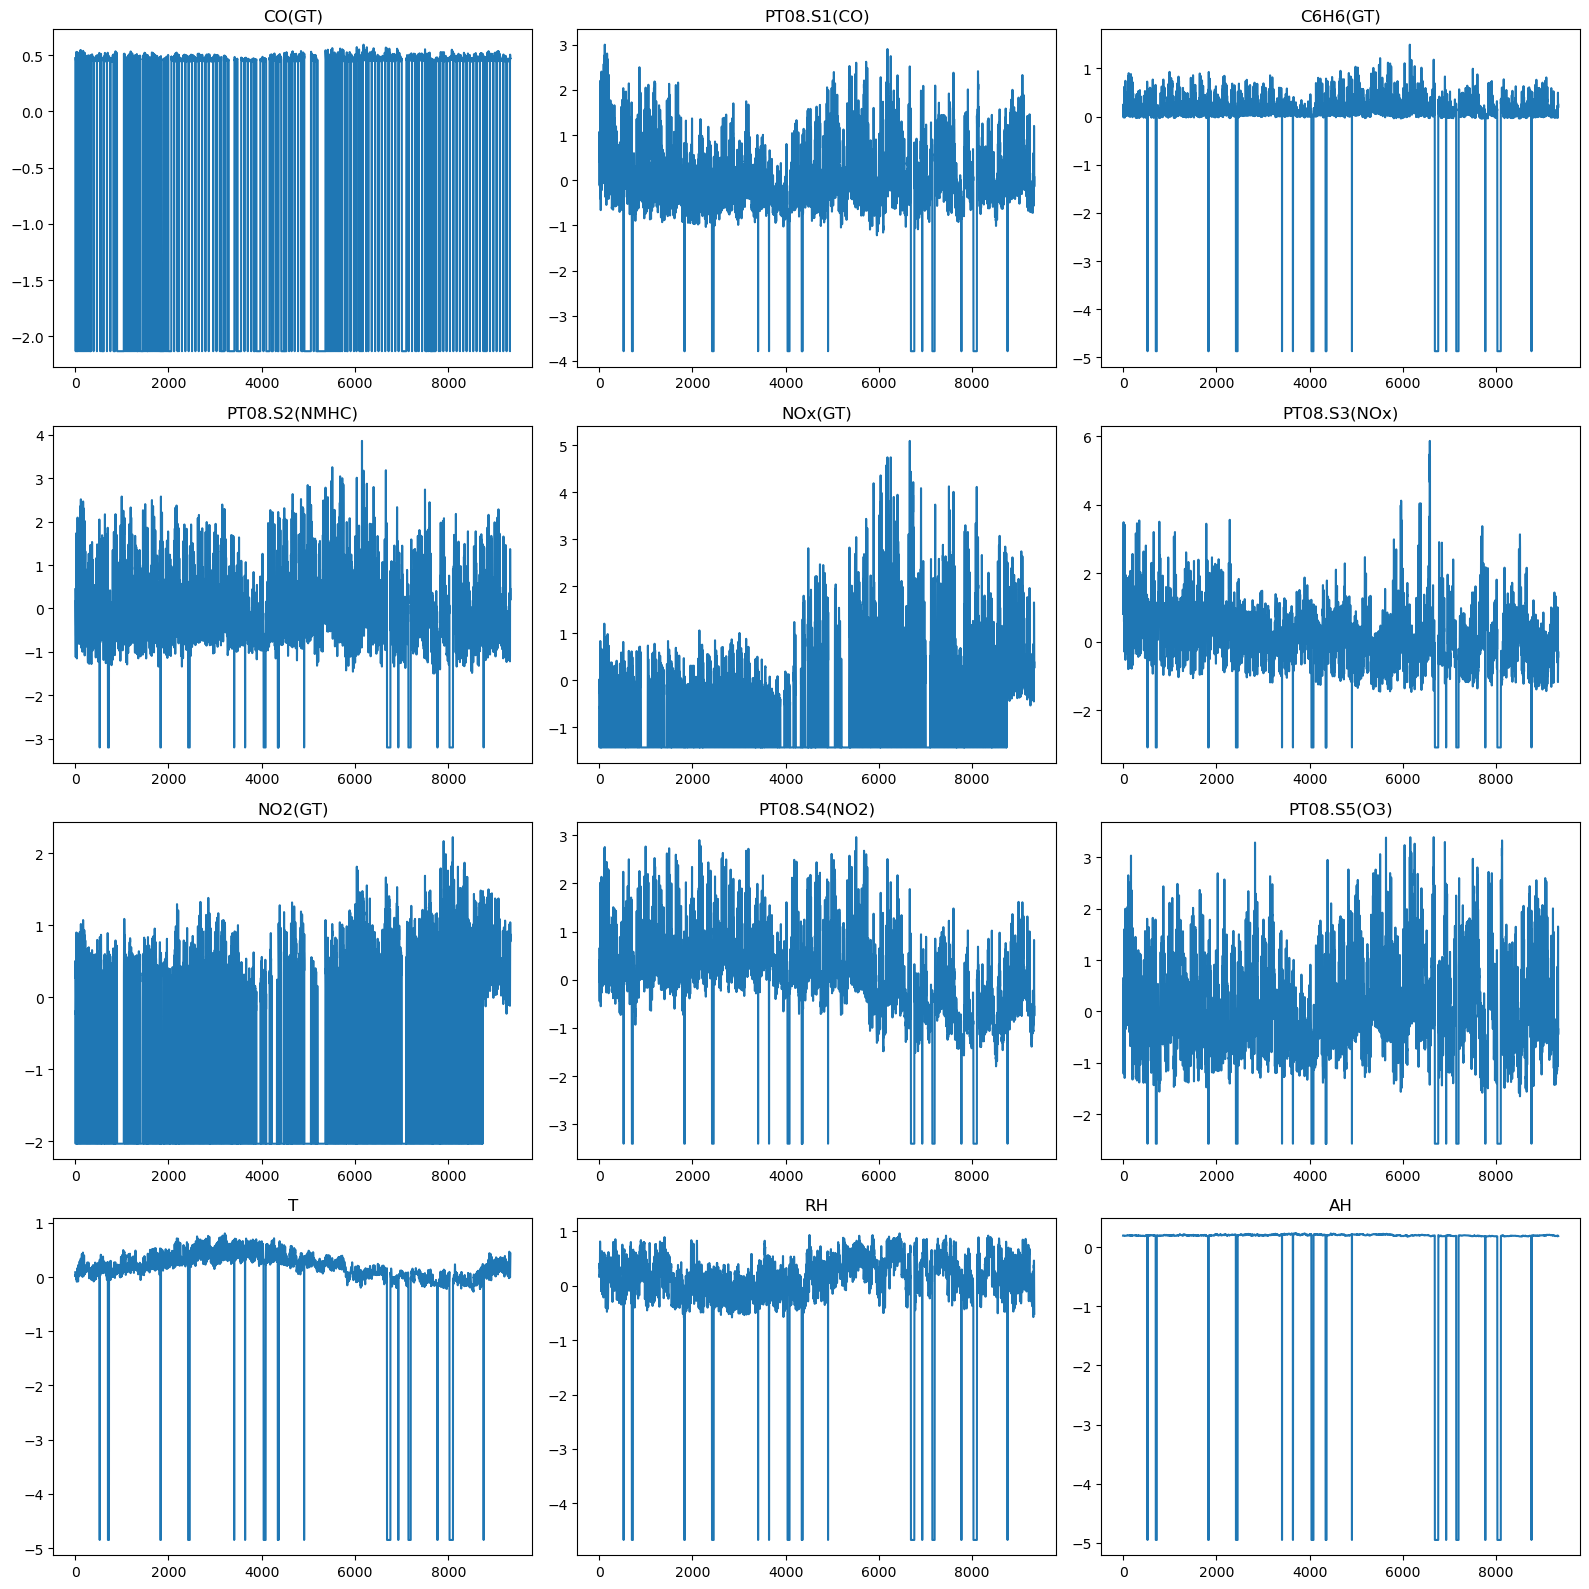

In [9]:
fig,axes=plt.subplots(4,3,figsize=(16,16))

axes=axes.flatten()

for i,column in enumerate(dataset.columns.drop('Time')):
    axes[i].plot(dataset[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

In [10]:
target_col=dataset['T']
dataset.drop('T',inplace=True,axis=1)
dataset.insert(len(dataset.columns),'T',target_col)
dataset.head()

,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,0.940047,0.474546,0.943296,0.242880,0.443203,-0.008701,0.809152,0.433984,0.643199,0.642210,0.183836,0.195140,0.088838
1,1.084513,0.466825,0.737249,0.182528,0.177446,-0.253354,1.175332,0.268586,0.358610,-0.005431,0.160429,0.194312,0.081902
2,1.228978,0.469399,1.070560,0.172872,0.130720,-0.144619,1.069823,0.441861,0.350051,0.217743,0.283314,0.194945,0.049531
3,1.373443,0.469399,0.991777,0.177700,0.157004,0.014600,0.920868,0.504870,0.412104,0.499992,0.400348,0.195880,0.028721
4,1.517909,0.461678,0.676647,0.112520,-0.170082,-0.144619,1.271532,0.457613,0.210966,0.296510,0.392546,0.195934,0.033345


In [14]:
def sliding_windows(data,n_step,n_out):
    X,y=list(),list()
    
    for i in range(len(data)):
        end_idx=i+n_step
        out_end_idx=end_idx+n_out
        
        if out_end_idx<=len(data):
            input_x=data[i:end_idx,:]
            input_x=input_x.reshape(n_step,len(dataset.columns))
            input_y=data[end_idx:out_end_idx,-1]
            X.append(input_x)
            y.append(input_y)
            
        
    return np.array(X),np.array(y)



In [15]:
import numpy as np
n_steps_in=648
n_out=24

n_features=len(dataset.columns)

train_size=int(len(dataset)*0.75)
train_df=dataset.iloc[:train_size,:]
test_df=dataset.iloc[train_size:,:]

trainX,trainY=sliding_windows(train_df.values,n_steps_in,n_out)
testX,testY=sliding_windows(test_df.values,n_steps_in,n_out)

print('TrainX',trainX.shape)
print('TrainY',trainY.shape)

TrainX (6329, 648, 13)
TrainY (6329, 24)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, BatchNormalization

model=Sequential()
model.add(LSTM(324,return_sequences=True,input_shape=(648,13),dropout=0.4))
model.add(LSTM(64,dropout=0.4))
model.add(Dense(24))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 648, 324)          438048    
                                                                 
 lstm_3 (LSTM)               (None, 64)                99584     
                                                                 
 dense_1 (Dense)             (None, 24)                1560      
                                                                 
Total params: 539192 (2.06 MB)
Trainable params: 539192 (2.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from keras import backend as K
from keras.callbacks import LearningRateScheduler
from keras.layers import TimeDistributed,RepeatVector
from tqdm import tqdm
def decay_schedule(epoch,lr):
    if (epoch%22==0) and (epoch!=0):
        lr=lr*0.5
    return lr
callbacks=[EarlyStopping(patience=30,monitor='loss')]
model.compile(loss='mse',optimizer='Adam')
K.set_value(model.optimizer.learning_rate,0.005)
lr_schedule=LearningRateScheduler(decay_schedule)
history=model.fit(trainX,trainY,epochs=70,batch_size=64,callbacks=[lr_schedule])


Epoch 1/70

99/99 [==============================] - 201s 2s/step - loss: 0.5948 - lr: 0.0050
Epoch 2/70
99/99 [==============================] - 204s 2s/step - loss: 0.5542 - lr: 0.0050
Epoch 3/70
99/99 [==============================] - 205s 2s/step - loss: 0.5613 - lr: 0.0050
Epoch 4/70
99/99 [==============================] - 207s 2s/step - loss: 0.5606 - lr: 0.0050
Epoch 5/70
99/99 [==============================] - 205s 2s/step - loss: 0.5340 - lr: 0.0050
Epoch 6/70
99/99 [==============================] - 206s 2s/step - loss: 0.5276 - lr: 0.0050
Epoch 7/70
99/99 [==============================] - 209s 2s/step - loss: 0.5209 - lr: 0.0050
Epoch 8/70
99/99 [==============================] - 208s 2s/step - loss: 0.5148 - lr: 0.0050
Epoch 9/70
99/99 [==============================] - 208s 2s/step - loss: 0.4934 - lr: 0.0050
Epoch 10/70
99/99 [==============================] - 211s 2s/step - loss: 0.4904 - lr: 0.0050
Epoch 11/70
99/99 [==============================] - 240s 2s/step - 

In [20]:
index=[i for i in range(0,len(testX)+1,24)]
input_x=testX[index,:,:]

In [22]:
y_pred=model.predict(input_x)

3/3 [==============================] - 2s 279ms/step


In [23]:
y_pred=y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])

In [24]:
y_pred=y_pred.tolist()


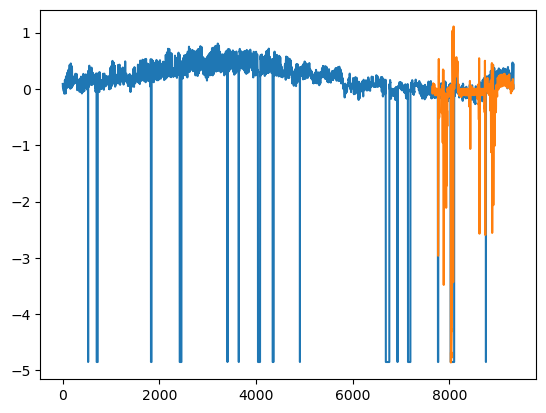

In [28]:
plt.plot(dataset['T'],label='Original data')
plt.plot(list(range(7649,9329)),y_pred,label='Prediction')

In [ ]:
from sklearn.